# The Deep Learning Homework 3 - Question No. 04 Part A-3
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10 and data Augmentation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

aug = False 

if aug == False:
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

else: 
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
  transAug1 = transforms.Compose([transforms.RandomRotation(90), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
  transAug2 = transforms.Compose([transforms.RandomResizedCrop(size=(32, 32),
                                         scale=(0.1, 1),
                                         ratio=(0.5, 2)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
  transAug3 = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  trainset += torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transAug1)
  trainset += torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transAug2)
  trainset += torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transAug3)


  trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

#imagefolder
'''i=0
for image in enumerate(train_set):
  i+=1
print(i)'''

100%|██████████| 170498071/170498071 [00:01<00:00, 105418750.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


'i=0\nfor image in enumerate(train_set):\n  i+=1\nprint(i)'

In [2]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Define a Convolutional Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [6]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [7]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

5852234

## Train the network

In [9]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [10]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [11]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:21<00:00, 72.44it/s]


Train Loss: 1.220 | Accuracy: 56.362


100%|██████████| 313/313 [00:04<00:00, 71.15it/s]


Test Loss: 0.868 | Accuracy: 69.130

Epoch : 2


100%|██████████| 1563/1563 [00:21<00:00, 73.21it/s]


Train Loss: 0.706 | Accuracy: 75.152


100%|██████████| 313/313 [00:04<00:00, 69.80it/s]


Test Loss: 0.660 | Accuracy: 77.000

Epoch : 3


100%|██████████| 1563/1563 [00:20<00:00, 74.66it/s]


Train Loss: 0.509 | Accuracy: 82.174


100%|██████████| 313/313 [00:04<00:00, 71.57it/s]


Test Loss: 0.598 | Accuracy: 79.270

Epoch : 4


100%|██████████| 1563/1563 [00:21<00:00, 73.13it/s]


Train Loss: 0.364 | Accuracy: 87.506


100%|██████████| 313/313 [00:05<00:00, 59.46it/s]


Test Loss: 0.570 | Accuracy: 80.850

Epoch : 5


100%|██████████| 1563/1563 [00:21<00:00, 73.57it/s]


Train Loss: 0.247 | Accuracy: 91.600


100%|██████████| 313/313 [00:04<00:00, 71.39it/s]


Test Loss: 0.605 | Accuracy: 80.070

Epoch : 6


100%|██████████| 1563/1563 [00:21<00:00, 73.27it/s]


Train Loss: 0.160 | Accuracy: 94.632


100%|██████████| 313/313 [00:04<00:00, 70.11it/s]


Test Loss: 0.660 | Accuracy: 80.560

Epoch : 7


100%|██████████| 1563/1563 [00:21<00:00, 73.15it/s]


Train Loss: 0.102 | Accuracy: 96.660


100%|██████████| 313/313 [00:04<00:00, 71.17it/s]


Test Loss: 0.681 | Accuracy: 81.520

Epoch : 8


100%|██████████| 1563/1563 [00:21<00:00, 73.57it/s]


Train Loss: 0.072 | Accuracy: 97.616


100%|██████████| 313/313 [00:04<00:00, 71.68it/s]


Test Loss: 0.750 | Accuracy: 80.940

Epoch : 9


100%|██████████| 1563/1563 [00:21<00:00, 73.65it/s]


Train Loss: 0.056 | Accuracy: 98.106


100%|██████████| 313/313 [00:04<00:00, 72.09it/s]


Test Loss: 0.782 | Accuracy: 81.080

Epoch : 10


100%|██████████| 1563/1563 [00:20<00:00, 74.43it/s]


Train Loss: 0.036 | Accuracy: 98.872


100%|██████████| 313/313 [00:04<00:00, 72.22it/s]


Test Loss: 0.820 | Accuracy: 81.590

Epoch : 11


100%|██████████| 1563/1563 [00:21<00:00, 73.87it/s]


Train Loss: 0.021 | Accuracy: 99.352


100%|██████████| 313/313 [00:04<00:00, 69.29it/s]


Test Loss: 0.785 | Accuracy: 82.590

Epoch : 12


100%|██████████| 1563/1563 [00:21<00:00, 73.69it/s]


Train Loss: 0.009 | Accuracy: 99.776


100%|██████████| 313/313 [00:04<00:00, 72.46it/s]


Test Loss: 0.819 | Accuracy: 82.670

Epoch : 13


100%|██████████| 1563/1563 [00:21<00:00, 73.22it/s]


Train Loss: 0.006 | Accuracy: 99.856


100%|██████████| 313/313 [00:04<00:00, 72.04it/s]


Test Loss: 0.814 | Accuracy: 82.870

Epoch : 14


100%|██████████| 1563/1563 [00:21<00:00, 72.84it/s]


Train Loss: 0.002 | Accuracy: 99.978


100%|██████████| 313/313 [00:04<00:00, 73.31it/s]


Test Loss: 0.820 | Accuracy: 83.810

Epoch : 15


100%|██████████| 1563/1563 [00:22<00:00, 69.15it/s]


Train Loss: 0.001 | Accuracy: 99.998


100%|██████████| 313/313 [00:04<00:00, 77.66it/s]


Test Loss: 0.807 | Accuracy: 83.910

Epoch : 16


100%|██████████| 1563/1563 [00:21<00:00, 71.64it/s]


Train Loss: 0.000 | Accuracy: 99.998


100%|██████████| 313/313 [00:03<00:00, 79.63it/s] 


Test Loss: 0.808 | Accuracy: 83.880

Epoch : 17


100%|██████████| 1563/1563 [00:21<00:00, 71.63it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 82.18it/s]


Test Loss: 0.814 | Accuracy: 83.950

Epoch : 18


100%|██████████| 1563/1563 [00:22<00:00, 70.66it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 84.15it/s]


Test Loss: 0.817 | Accuracy: 83.910

Epoch : 19


100%|██████████| 1563/1563 [00:22<00:00, 70.80it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 91.30it/s]


Test Loss: 0.822 | Accuracy: 83.850

Epoch : 20


100%|██████████| 1563/1563 [00:22<00:00, 70.71it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.48it/s]


Test Loss: 0.832 | Accuracy: 83.890

Epoch : 21


100%|██████████| 1563/1563 [00:21<00:00, 71.80it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 83.25it/s]


Test Loss: 0.827 | Accuracy: 83.930

Epoch : 22


100%|██████████| 1563/1563 [00:22<00:00, 69.59it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.27it/s]


Test Loss: 0.835 | Accuracy: 84.050

Epoch : 23


100%|██████████| 1563/1563 [00:22<00:00, 70.23it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.63it/s]


Test Loss: 0.836 | Accuracy: 83.920

Epoch : 24


100%|██████████| 1563/1563 [00:22<00:00, 70.09it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 93.83it/s]


Test Loss: 0.843 | Accuracy: 83.860

Epoch : 25


100%|██████████| 1563/1563 [00:22<00:00, 69.31it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.97it/s]


Test Loss: 0.847 | Accuracy: 84.070

Epoch : 26


100%|██████████| 1563/1563 [00:23<00:00, 66.75it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.36it/s]


Test Loss: 0.846 | Accuracy: 83.990

Epoch : 27


100%|██████████| 1563/1563 [00:22<00:00, 70.48it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.81it/s]


Test Loss: 0.845 | Accuracy: 84.040

Epoch : 28


100%|██████████| 1563/1563 [00:22<00:00, 70.09it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.01it/s]


Test Loss: 0.852 | Accuracy: 83.890

Epoch : 29


100%|██████████| 1563/1563 [00:22<00:00, 70.17it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 94.15it/s]


Test Loss: 0.850 | Accuracy: 83.960

Epoch : 30


100%|██████████| 1563/1563 [00:22<00:00, 70.60it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 93.90it/s] 


Test Loss: 0.855 | Accuracy: 84.080

Epoch : 31


100%|██████████| 1563/1563 [00:23<00:00, 67.51it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.76it/s]


Test Loss: 0.856 | Accuracy: 84.090

Epoch : 32


100%|██████████| 1563/1563 [00:22<00:00, 70.23it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.97it/s]


Test Loss: 0.859 | Accuracy: 83.990

Epoch : 33


100%|██████████| 1563/1563 [00:22<00:00, 70.32it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.22it/s]


Test Loss: 0.861 | Accuracy: 84.010

Epoch : 34


100%|██████████| 1563/1563 [00:22<00:00, 70.30it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.70it/s]


Test Loss: 0.868 | Accuracy: 84.010

Epoch : 35


100%|██████████| 1563/1563 [00:22<00:00, 70.29it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 96.34it/s]


Test Loss: 0.868 | Accuracy: 83.990

Epoch : 36


100%|██████████| 1563/1563 [00:23<00:00, 67.07it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 87.30it/s]


Test Loss: 0.864 | Accuracy: 84.060

Epoch : 37


100%|██████████| 1563/1563 [00:22<00:00, 69.51it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 94.50it/s]


Test Loss: 0.867 | Accuracy: 84.080

Epoch : 38


100%|██████████| 1563/1563 [00:22<00:00, 69.76it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 94.10it/s]


Test Loss: 0.871 | Accuracy: 84.010

Epoch : 39


100%|██████████| 1563/1563 [00:22<00:00, 69.92it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.06it/s]


Test Loss: 0.874 | Accuracy: 83.910

Epoch : 40


100%|██████████| 1563/1563 [00:22<00:00, 68.35it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.86it/s]


Test Loss: 0.871 | Accuracy: 84.040

Epoch : 41


100%|██████████| 1563/1563 [00:23<00:00, 67.78it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 93.13it/s]


Test Loss: 0.879 | Accuracy: 84.000

Epoch : 42


100%|██████████| 1563/1563 [00:24<00:00, 65.05it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.72it/s]


Test Loss: 0.875 | Accuracy: 84.070

Epoch : 43


100%|██████████| 1563/1563 [00:22<00:00, 68.52it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.20it/s]


Test Loss: 0.884 | Accuracy: 83.880

Epoch : 44


100%|██████████| 1563/1563 [00:23<00:00, 67.36it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 94.49it/s]


Test Loss: 0.876 | Accuracy: 84.030

Epoch : 45


100%|██████████| 1563/1563 [00:22<00:00, 68.89it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.35it/s]


Test Loss: 0.880 | Accuracy: 84.130

Epoch : 46


100%|██████████| 1563/1563 [00:22<00:00, 69.24it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.22it/s]


Test Loss: 0.886 | Accuracy: 84.050

Epoch : 47


100%|██████████| 1563/1563 [00:23<00:00, 65.89it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 70.73it/s]


Test Loss: 0.882 | Accuracy: 83.920

Epoch : 48


100%|██████████| 1563/1563 [00:21<00:00, 71.80it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.66it/s]


Test Loss: 0.886 | Accuracy: 83.990

Epoch : 49


100%|██████████| 1563/1563 [00:21<00:00, 72.06it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 70.61it/s]


Test Loss: 0.889 | Accuracy: 84.040

Epoch : 50


100%|██████████| 1563/1563 [00:22<00:00, 69.83it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 72.56it/s]

Test Loss: 0.892 | Accuracy: 84.130


## Drowing plots

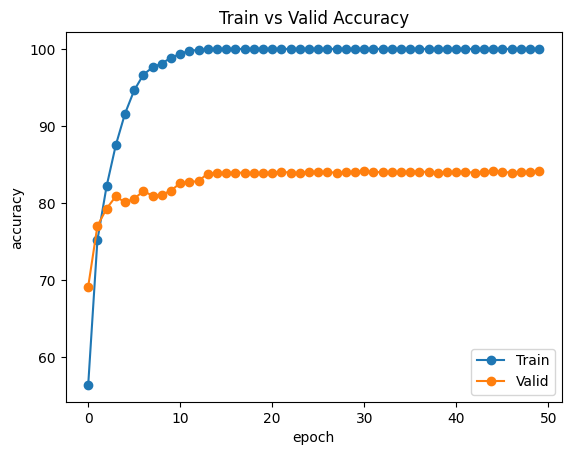

In [12]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

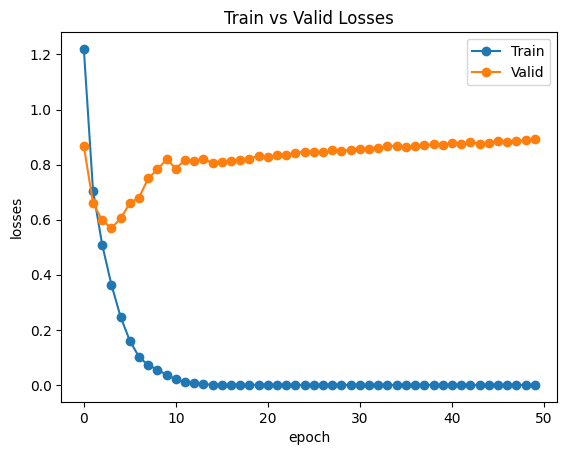

In [13]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [14]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:03<00:00, 88.44it/s]


In [15]:
print(y_pred)
print(y_true)

[3, 8, 1, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 2, 4, 9, 4, 3, 3, 0, 9, 6, 6, 5, 4, 5, 9, 6, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 5, 5, 6, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 3, 8, 8, 0, 2, 9, 3, 5, 8, 8, 1, 1, 7, 2, 7, 2, 7, 8, 9, 0, 6, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 3, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 5, 8, 7, 6, 6, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 2, 4, 2, 1, 4, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 3, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 8, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 0, 5, 9, 8, 2, 7, 9, 8, 2, 4, 3, 9, 5, 4, 9, 6, 4, 3, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 2, 1, 8, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 8, 9, 8, 1, 5, 3, 8, 8, 2, 4, 7, 0, 2, 5, 6, 3, 8, 5, 0, 2, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 1, 3, 4, 6, 0, 0, 6, 6, 6, 5, 2, 6, 1, 9, 2, 1, 4, 8, 6, 0, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 2, 4, 1, 7, 5, 4, 6, 1, 9, 6, 

In [16]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [17]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [18]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,876,6,27,14,10,3,3,2,38,21
automobile,7,924,0,6,2,2,2,0,13,44
bird,50,5,761,37,44,30,46,17,6,4
cat,16,5,60,696,32,108,38,23,13,9
deer,13,0,44,41,806,20,33,35,6,2
dog,15,4,34,101,31,773,9,32,0,1
frog,6,3,26,35,16,12,891,4,3,4
horse,12,1,15,27,29,28,6,876,0,6
ship,44,15,5,6,1,5,3,4,899,18
truck,21,38,4,6,2,0,2,4,12,911


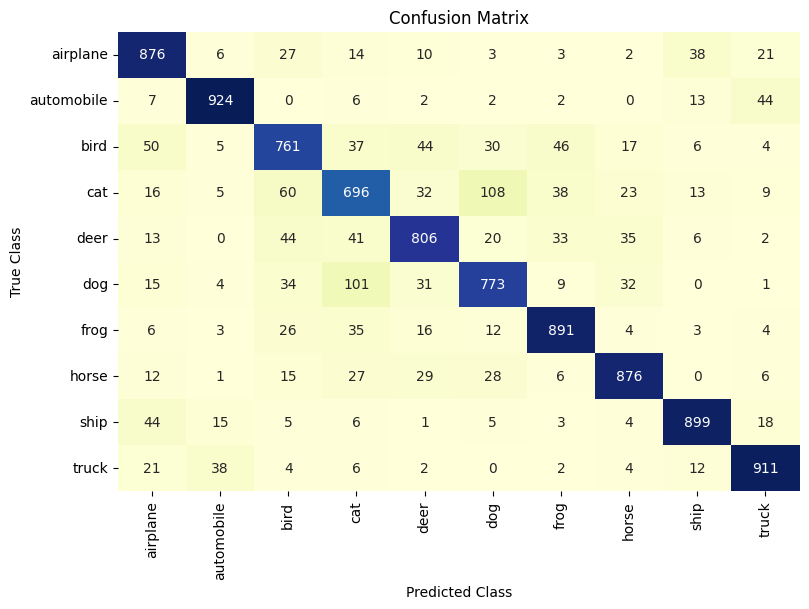

In [19]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()